# Combining models
****
Here we will combine the classifier who chose to first classify each observation into a range for 'logerror' and then within each range, run a regression.

In [24]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from imblearn.combine import SMOTETomek
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [25]:
Housing = pd.read_csv('cleaned_1.csv')
Housing = Housing.set_index(['parcelid','Unnamed: 0'])
Housing['transactiondate'] = pd.to_datetime(Housing['transactiondate'], format = '%Y-%m-%d', errors = 'coerce')
Housing['taxamount'] = Housing['taxamount']*100
#bins = [-5.5,-2,-0.1,0.1,0.75,2,5.5]
#Housing['binned'] = pd.cut(Housing['logerror'], bins = bins, labels= bins[1:])
#Housing['binned'].value_counts()

imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
            'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
            'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
            'regionidneighborhood','fips']

X_df = Housing[imp_cols].astype(int)
Y_df = Housing['logerror']#Housing['binned'].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df)

Y_df.head()

parcelid  Unnamed: 0
17073783  0             0.0953
17088994  1             0.0198
17100444  2             0.0060
17102429  3            -0.0566
17109604  4             0.0573
Name: logerror, dtype: float64

In [26]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 1
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        #print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        #print( 'num of unpredictable data: ', numunperdicted )
        return enc
    #else:
        #print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

def zoningcode_int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    df[ target ]= enc.fit_transform( df[ target ].values )
    df.loc[ storenull, target ] = np.nan
    return enc

def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    knn.fit(X_train, Y_train)
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[combined_df[target].isnull(),target] = pred
    return

In [27]:
def Double_Model(X_predict, X_train, y_train, evalu = False):
    # First we will do some cleaning
    bins = [-5.5,-2,-0.2,0.2,0.75,2,5.5]
    #train_bins = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
            'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
            'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
            'regionidneighborhood']
    X_train['binned'] = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    y_df = pd.DataFrame()
    y_df['logerror'] = y_train
    y_df['binned'] = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    
    X_predict = X_predict.sort_index()
    # HERE WE WILL FILL IN NULL VALUES IF NECESSARY
    # Additionall, we may need to prepare the data if it is to be inputted raw
    
    
    #if X_predict['buildingqualitytypeid'].isnull().values.any() == True:
        #fillna_knn(df = X_predict, base = ['latitude', 'longitude'], target = 'buildingqualitytypeid')
    #if X_predict['regionidneighborhood'].isnull().values.any() == True:
        #fillna_knn(df = X_predict, base = ['latitude', 'longitude'], target = 'regionidneighborhood')
    #if X_predict['regionidzip'].isnull().values.any() == True:
        #fillna_knn(df = X_predict, base = ['latitude', 'longitude'], target = 'regionidzip')
    #if X_predict['lotsizesquarefeet'].isnull().values.any() == True:
        #fillna_knn(df = X_predict, base = ['latitude', 'longitude'], target = 'lotsizesquarefeet')
    #if X_predict['structuretaxvaluedollarcnt'].isnull().values.any() == True:
        #fillna_knn_reg(df = X_predict, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt')
    #if X_predict['taxamount'].isnull().values.any() == True:
        #fillna_knn_reg(df = X_predict, base = ['taxvaluedollarcnt'], target = 'taxamount')
    
    
    # Here we adjust taxamount IF NEEDED IN MODEL
    
    
    
    
    
    smt = SMOTETomek(ratio='auto', n_jobs = 4)
    X_smt, y_smt = smt.fit_sample(X_train[imp_cols], X_train['binned'])
    
    clf_boost = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5)
    clf_boost.fit(X_smt, y_smt)
    
    #clf = RandomForestClassifier(n_estimators = 10, max_features = 3, bootstrap = True, random_state = 5)
    #clf.fit(X_train[imp_cols], X_train['binned'])
    
    predicted_bins = clf_boost.predict(X_predict[imp_cols])
    X_predict['binned'] = predicted_bins
    
    predicted_dfs = []
    for i in X_train['binned'].unique():
        #X_train['tax_deviation'] = abs((X_train['structuretaxvaluedollarcnt'] 
                                        # - X_train['regionidcity'].map(group)))/X_train['regionidcity'].map(group)
        #X_predict['tax_deviation'] = abs((X_predict['structuretaxvaluedollarcnt'] 
                                        # - X_predict['regionidcity'].map(group)))/X_predict['regionidcity'].map(group)
        df_train = X_train[X_train['binned'] == i]
        df_y_train = y_df[y_df['binned'] == i]
        df_pred = X_predict[X_predict['binned'] == i]
        #df_predict = df_pred[imp_cols]
        
        df_train = df_train.astype(float)
        df_pred = df_pred.astype(float)
        df_train['taxamount'] = df_train['taxamount'] / 100
        df_pred['taxamount'] = df_pred['taxamount'] / 100
        
        #poly = PolynomialFeatures(degree=2)
        #X_train_poly = poly.fit_transform(df_train[imp_cols])
        #X_test_poly = poly.fit_transform(df_pred[imp_cols])
        #lr = LinearRegression().fit(X_train_poly, df_y_train['logerror'])
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(df_train[imp_cols])
        X_test_scaled = scaler.transform(df_pred[imp_cols])
        linridge = Ridge(alpha=0.1).fit(X_train_scaled, df_y_train['logerror'])
        
        #mlp = MLPRegressor(hidden_layer_sizes = [100,100], alpha = 1, solver = 'lbfgs').fit(df_train[imp_cols],
                                                                                            #df_y_train['logerror'])
        
        #df_pred['predicted'] = lr.predict(X_test_poly)
        df_pred['predicted'] = linridge.predict(X_test_scaled)
        #df_pred['predicted'] = mlp.predict(df_pred[imp_cols])
        predicted_dfs.append(df_pred['predicted'])
        
        if evalu == True:
            score_ridge = linridge.score(X_train_scaled, df_y_train['logerror'])
            #score_poly = lr.score(X_train_scaled, df_y_train['logerror'])
            print('The ridge score for cat: ', i, ' is ',  score_ridge)
            #print('The poly score for cat: ', i, ' is ',  score_poly)
    
    S = predicted_dfs[0].append(predicted_dfs[1:])
    
    S = S.sort_index()
    return S

#Double_Model(X_test, X_train, y_train)

In [28]:
y_test

Results = pd.DataFrame()
Results['predicted'] = Double_Model(X_test, X_train, y_train, evalu = True)
Results['real'] = y_test

print("Mean squared error: {:.2f}".format(mean_squared_error(Results['real'], Results['predicted'])))
print("r2_score: {:.2f}".format(r2_score(Results['real'], Results['predicted'])))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


The ridge score for cat:  2  is  0.010635898886060091
The ridge score for cat:  3  is  0.0086804993087084
The ridge score for cat:  1  is  0.03400228123491689
The ridge score for cat:  4  is  0.05473911995455583
The ridge score for cat:  5  is  0.32035195702732056
The ridge score for cat:  0  is  0.23368831025481385
Mean squared error: 0.05
r2_score: -0.75


mean squared error 0.07 for $(-0.1,0.1)$

In [8]:
Results['predicted'].max()

5.995496976843874

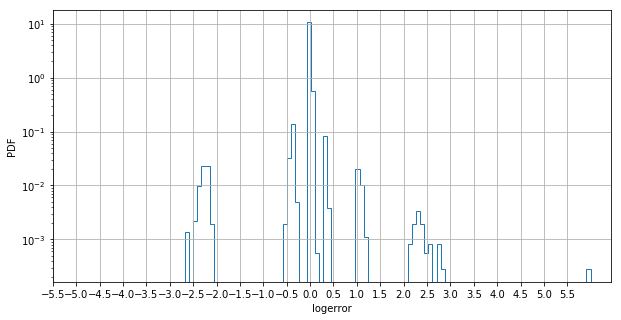

In [9]:
x=[-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5]

plt.figure(figsize = (10,5))
plt.hist(Results['predicted'], bins=100, density=True, histtype='step')
#plt.hist(Results['real'], bins=100, density=True, histtype='step')
plt.yscale('log')
plt.xlabel('logerror')
plt.xticks(x)
#plt.xlim([-6,6])
plt.ylabel('PDF')
plt.grid(True)

In [20]:
Results['zeros'] = 0#basis_model = np.full((len(Results['predicted']),1), 0)
Results.head()

,,predicted,real,zeros
parcelid,Unnamed: 0,,,
10711755,83007,0.000790,-0.018200,0
10711858,84331,0.003583,-0.048100,0
10711995,66220,0.003228,0.041138,0
10712184,36189,0.003073,0.041968,0
10712195,50456,0.004506,-0.045000,0


In [23]:
print("Mean squared error: {:.2f}".format(mean_squared_error(Results['real'], Results['zeros'])))
print("r2_score: {:.2f}".format(r2_score(Results['real'], Results['zeros'])))

Mean squared error: 0.03
r2_score: -0.01
